# Titanic: Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')

### Feature engineering and Feature Selection

In [3]:
test.loc[test['Cabin'].isna()==True,'Cabin'] = 'Z'
train.loc[train['Cabin'].isna()==True,'Cabin'] = 'Z'
def split(word):
    return [char for char in word]

In [4]:
# extract the title
train['Title'] = train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
test['Title'] = test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [5]:
# simplify code using encode = ['Sex','AgeRange','Cabin']
dummies = pd.get_dummies(train.Sex)
for i in train['Sex'].unique():
    train[i] = 0
for i in train['Sex'].unique():
    train.loc[:,i] =  dummies[i]
#train = train.drop(['Sex'], axis=1) 
train.head()
dummies = pd.get_dummies(test.Sex)
for i in test['Sex'].unique():
    test[i] = 0
for i in test['Sex'].unique():
    test.loc[:,i] =  dummies[i]
#test = test.drop(['Sex'], axis=1) 

In [6]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [7]:
train[train['Embarked'].isna()==True][['Name','Sex','Ticket','Embarked','Cabin']]

,Name,Sex,Ticket,Embarked,Cabin
61,"Icard, Miss. Amelie",female,113572,NaN,B28
829,"Stone, Mrs. George Nelson (Martha Evelyn)",female,113572,NaN,B28


 After google one of the passengers (https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) found that the Embarked value is 'S' since the other passenger has the same ticket number means they travelled together and so both Embarked from the same location

In [8]:
train['Embarked'] = train['Embarked'].fillna('S')

In [9]:
train['Ticket_freq'] = train.groupby('Ticket')['Ticket'].transform('count')
test['Ticket_freq'] = test.groupby('Ticket')['Ticket'].transform('count')

In [10]:
# SibSp + Parch gives family size
train['Family'] = train['SibSp'] + train['Parch'] + 1
test['Family'] = test['SibSp'] + test['Parch'] + 1

In [11]:
test.loc[test['Cabin'].isna()==True,'Cabin'] = 'Z'
train.loc[train['Cabin'].isna()==True,'Cabin'] = 'Z'
def split(word):
    return [char for char in word]
train['Cabin'] = [split(i) for i in train['Cabin']]
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Z']
a = []
for i in train['Cabin']:
    b = []
    for j in i:
        if j in cabin_list:
            b.append(j)
    a.append(b)
train['Cabin'] = a
# select the highest deck for passengers with multiple decks booked
train['Cabin'] = [min(i) for i in train['Cabin']]

test['Cabin'] = [split(i) for i in test['Cabin']]
a = []
for i in test['Cabin']:
    b = []
    for j in i:
        if j in cabin_list:
            b.append(j)
    a.append(b)
test['Cabin'] = a
test['Cabin'] = [min(i) for i in test['Cabin']]

In [12]:
print(train.groupby('Pclass')['Cabin'].value_counts().unstack().fillna(0))

Cabin      A     B     C     D     E    F    G    T      Z
Pclass                                                    
1       15.0  47.0  59.0  29.0  25.0  0.0  0.0  1.0   40.0
2        0.0   0.0   0.0   4.0   4.0  8.0  0.0  0.0  168.0
3        0.0   0.0   0.0   0.0   4.0  4.0  4.0  0.0  479.0


In [13]:
print(test.groupby('Pclass')['Cabin'].value_counts().unstack().fillna(0))

Cabin     A     B     C     D    E    F    G      Z
Pclass                                             
1       7.0  18.0  35.0  11.0  9.0  0.0  0.0   27.0
2       0.0   0.0   0.0   2.0  0.0  5.0  0.0   86.0
3       0.0   0.0   0.0   0.0  2.0  1.0  1.0  214.0


Cabin A,B,T and C are the same class <br>
Cabin G is 3rd class

In [14]:
train['Cabin'] = train['Cabin'].replace(['A', 'B', 'C','T'], 'ABC')
test['Cabin'] = test['Cabin'].replace(['A', 'B', 'C'], 'ABC')

In [15]:
print(train.groupby('Pclass')['Cabin'].value_counts().unstack().fillna(0))

Cabin     ABC     D     E    F    G      Z
Pclass                                    
1       122.0  29.0  25.0  0.0  0.0   40.0
2         0.0   4.0   4.0  8.0  0.0  168.0
3         0.0   0.0   4.0  4.0  4.0  479.0


In [16]:
print(round(train.groupby('Cabin')['Fare'].mean()))
print(round(train.groupby('Cabin')['Fare'].median()))

Cabin
ABC    97.0
D      57.0
E      45.0
F      18.0
G      14.0
Z      19.0
Name: Fare, dtype: float64
Cabin
ABC    79.0
D      53.0
E      38.0
F      12.0
G      14.0
Z      10.0
Name: Fare, dtype: float64


In [17]:
test[test['Fare'].isna()==True]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,male,female,Ticket_freq,Family
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,Z,S,Mr,1,0,1,1


In [18]:
fare_med = test.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
test['Fare'] = test['Fare'].fillna(fare_med)

In [19]:
# Add column age range 
train['AgeRange'] = None
train.loc[train['Age']<13,'AgeRange'] = 'Child'
train.loc[(train['Age']>=13)&(train['Age']<21),'AgeRange'] = 'Teen'
train.loc[train['Age']>=21,'AgeRange'] = 'Adult'
train.loc[(train['Parch']==0)&(train['Age'].isna()==True),'AgeRange'] = 'Child'
train.loc[train['AgeRange'].isna()==True,'AgeRange'] = 'Teen_Adult'
# drop Age column
#train = train.drop(['Age'], axis=1) 
test['AgeRange'] = None
test.loc[test['Age']<13,'AgeRange'] = 'Child'
test.loc[(test['Age']>=13)&(test['Age']<21),'AgeRange'] = 'Teen'
test.loc[test['Age']>=21,'AgeRange'] = 'Adult'
test.loc[(test['Parch']==0)&(test['Age'].isna()==True),'AgeRange'] = 'Child'
test.loc[test['AgeRange'].isna()==True,'AgeRange'] = 'Teen_Adult'

In [20]:
# one hot encoding for Embarked
dummies = pd.get_dummies(train.Embarked)
for i in train['Embarked'].unique():
    train[i+'E'] = 0
for i in train['Embarked'].unique():
    train.loc[:,i+'E'] =  dummies[i]
dummies = pd.get_dummies(test.Embarked)
for i in test['Embarked'].unique():
    test[i+'E'] = 0
for i in test['Embarked'].unique():
    test.loc[:,i+'E'] =  dummies[i]

In [21]:
# one hot encoding for age
dummies = pd.get_dummies(train.AgeRange)
for i in train['AgeRange'].unique():
    train[i] = 0
for i in train['AgeRange'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.AgeRange)
for i in test['AgeRange'].unique():
    test[i] = 0

for i in test['AgeRange'].unique():
    test.loc[:,i] =  dummies[i]


In [22]:
# one hot encoding for Cabin
dummies = pd.get_dummies(train.Cabin)
for i in train['Cabin'].unique():
    train[i] = 0
for i in train['Cabin'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.Cabin)
for i in test['Cabin'].unique():
    test[i] = 0

for i in test['Cabin'].unique():
    test.loc[:,i] =  dummies[i]

In [23]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Too many titles to perform one hot encoding. Group the titles to reduce demention

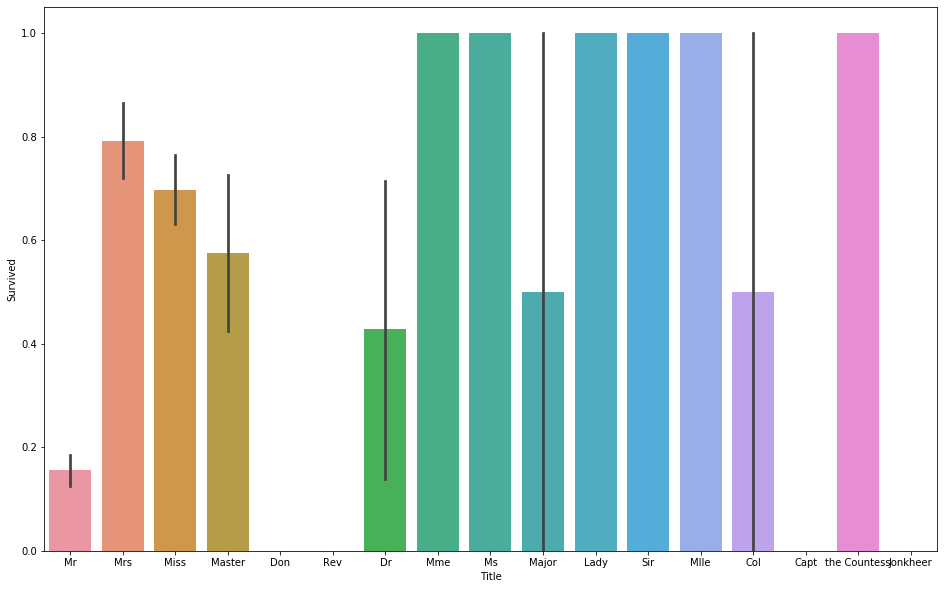

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in ['Title']:
    plt.figure(figsize=(16, 10))
    sns.barplot(x=i,y='Survived',data=train)
    plt.show()

In [25]:
print(train['Title'].unique())
print(test['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [26]:
train['Title'] = train['Title'].replace(['Ms', 'Dona','Mme','Mlle','Jonkheer'], 'Single Women')
test['Title'] = test['Title'].replace(['Ms', 'Dona', 'Mlle'], 'Single Women')

train['Title'] = train['Title'].replace(['Mrs', 'the Countess'], 'Married Women')
test['Title'] = test['Title'].replace(['Mrs'], 'Married Women')
train['Title'] = train['Title'].replace(['Miss', 'Lady'], 'Miss/Lady')
test['Title'] = test['Title'].replace(['Miss'], 'Miss/Lady')

train['Title'] = train['Title'].replace(['Dr', 'Rev','Don','Major','Col','Capt'], 'Speciality Profession')
train['Title'] = train['Title'].replace(['Mr','Sir'], 'Mr/Sir')

test['Title'] = test['Title'].replace(['Dr', 'Rev','Col'], 'Speciality Profession')
test['Title'] = test['Title'].replace(['Mr','Sir'], 'Mr/Sir')

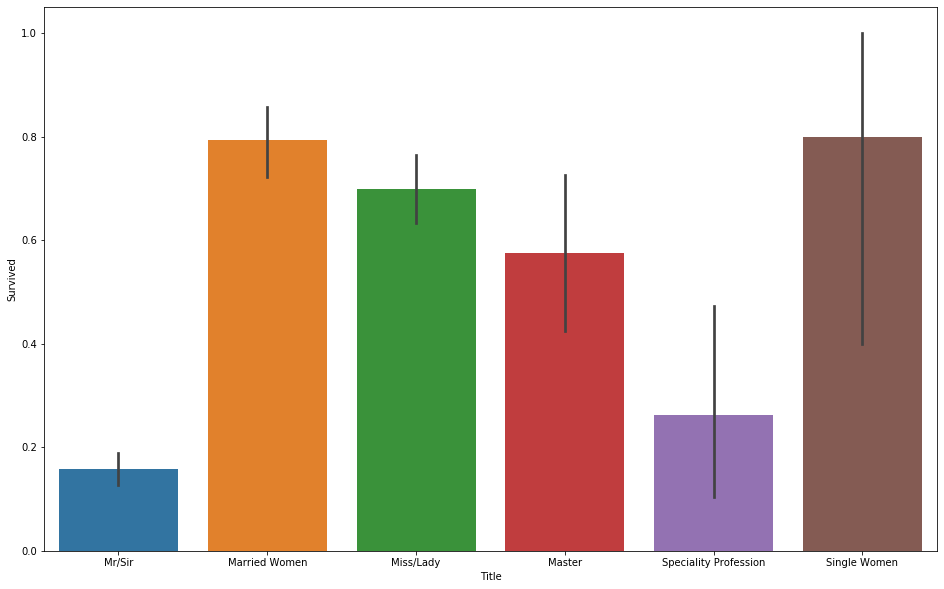

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in ['Title']:
    plt.figure(figsize=(16, 10))
    sns.barplot(x=i,y='Survived',data=train)
    plt.show()

In [28]:
# one hot encoding for Title
dummies = pd.get_dummies(train.Title)
for i in train['Title'].unique():
    train[i] = 0
for i in train['Title'].unique():
    train.loc[:,i] =  dummies[i]
    
dummies = pd.get_dummies(test.Title)
for i in test['Title'].unique():
    test[i] = 0

for i in test['Title'].unique():
    test.loc[:,i] =  dummies[i]

In [29]:
# one hot encoding for Pclass
dummies = pd.get_dummies(train.Pclass)
for i in train['Pclass'].unique():
    train[str(i)+'_Pclass'] = 0
for i in train['Pclass'].unique():
    train.loc[:,str(i)+'_Pclass'] =  dummies[i]
    
dummies = pd.get_dummies(test.Family)
for i in test['Pclass'].unique():
    test[str(i)+'_Pclass'] = 0

for i in test['Pclass'].unique():
    test.loc[:,str(i)+'_Pclass'] =  dummies[i]

In [30]:
# one hot encoding for Family
dummies = pd.get_dummies(train.Family)
for i in train['Family'].unique():
    train[str(i)+'_Family'] = 0
for i in train['Family'].unique():
    train.loc[:,str(i)+'_Family'] =  dummies[i]
    
dummies = pd.get_dummies(test.Family)
for i in test['Family'].unique():
    test[str(i)+'_Family'] = 0

for i in test['Family'].unique():
    test.loc[:,str(i)+'_Family'] =  dummies[i]

In [31]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'male',
       'female', 'Ticket_freq', 'Family', 'AgeRange', 'SE', 'CE', 'QE',
       'Adult', 'Child', 'Teen', 'Teen_Adult', 'Z', 'ABC', 'E', 'G', 'D', 'F',
       'Mr/Sir', 'Married Women', 'Miss/Lady', 'Master',
       'Speciality Profession', 'Single Women', '3_Pclass', '1_Pclass',
       '2_Pclass', '2_Family', '1_Family', '5_Family', '3_Family', '7_Family',
       '6_Family', '4_Family', '8_Family', '11_Family'],
      dtype='object')

In [32]:
sorted_pairs = train[train.columns.difference(['PassengerId','Survived','SibSp',
                                'Parch','male','Fare'])].corr().unstack().sort_values(
                                                                        kind="quicksort")
sorted_pairs[sorted_pairs < -0.5] 

Pclass     1_Pclass    -0.885924
1_Pclass   Pclass      -0.885924
female     Mr/Sir      -0.869335
Mr/Sir     female      -0.869335
1_Pclass   Z           -0.788773
Z          1_Pclass    -0.788773
CE         SE          -0.782742
SE         CE          -0.782742
Z          ABC         -0.730937
ABC        Z           -0.730937
Child      Adult       -0.712984
Adult      Child       -0.712984
Family     1_Family    -0.690922
1_Family   Family      -0.690922
3_Pclass   1_Pclass    -0.626738
1_Pclass   3_Pclass    -0.626738
Pclass     ABC         -0.623790
ABC        Pclass      -0.623790
Miss/Lady  Mr/Sir      -0.599128
Mr/Sir     Miss/Lady   -0.599128
2_Family   1_Family    -0.578412
1_Family   2_Family    -0.578412
2_Pclass   3_Pclass    -0.565210
3_Pclass   2_Pclass    -0.565210
Child      Age         -0.561675
Age        Child       -0.561675
dtype: float64

In [33]:
print(sorted_pairs[(sorted_pairs > 0.5)])

Family                 11_Family                0.501916
11_Family              Family                   0.501916
Z                      3_Pclass                 0.539291
3_Pclass               Z                        0.539291
female                 Married Women            0.550146
Married Women          female                   0.550146
Teen_Adult             11_Family                0.587242
11_Family              Teen_Adult               0.587242
Adult                  Age                      0.680069
Age                    Adult                    0.680069
Miss/Lady              female                   0.689179
female                 Miss/Lady                0.689179
ABC                    1_Pclass                 0.704112
1_Pclass               ABC                      0.704112
Pclass                 Z                        0.725541
Z                      Pclass                   0.725541
Ticket_freq            Family                   0.748487
Family                 Ticket_f

## Model

In [34]:
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [35]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'male', 'female',
       'Ticket_freq', 'Family', 'AgeRange', 'QE', 'SE', 'CE', 'Adult', 'Teen',
       'Child', 'Teen_Adult', 'Z', 'ABC', 'E', 'D', 'F', 'G', 'Mr/Sir',
       'Married Women', 'Miss/Lady', 'Master', 'Single Women',
       'Speciality Profession', '3_Pclass', '2_Pclass', '1_Pclass', '1_Family',
       '2_Family', '3_Family', '5_Family', '4_Family', '6_Family', '8_Family',
       '7_Family', '11_Family'],
      dtype='object')

In [36]:
seed = 42
train = train.sample(frac=1).reset_index(drop=True)
clf = tree.DecisionTreeClassifier(random_state=seed,criterion='entropy',
                                 min_samples_split=4,min_samples_leaf=5)
features = ['Pclass','Family','male','female','Child',
            'Adult','Teen','Teen_Adult','Z', 'ABC', 'E',
            'D', 'F', 'G', 'SE', 'CE', 'QE','Mr/Sir',
            'Married Women', 'Miss/Lady', 'Master', 
            'Single Women', 'Speciality Profession',
            '1_Family','2_Family', '3_Family','5_Family', 
            '4_Family', '6_Family', '8_Family','7_Family', 
            '11_Family']
X = train[features]
Y = train['Survived']
clf = clf.fit(X, Y)

In [37]:
# predict which passengers survived using the trained model
submit['Survived'] = clf.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_dt1.csv', index=False)
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

Mr/Sir                   0.480716
Pclass                   0.142765
Family                   0.096530
Speciality Profession    0.082843
Z                        0.057549
7_Family                 0.021861
Child                    0.020969
ABC                      0.015081
Adult                    0.012231
Master                   0.010576
SE                       0.008938
F                        0.008384
Teen                     0.008104
2_Family                 0.007566
CE                       0.006248
QE                       0.006095
Married Women            0.004551
D                        0.002832
4_Family                 0.002405
1_Family                 0.002170
Miss/Lady                0.001586
8_Family                 0.000000
male                     0.000000
female                   0.000000
6_Family                 0.000000
3_Family                 0.000000
5_Family                 0.000000
Teen_Adult               0.000000
E                        0.000000
Single Women  

Base score of 72.4

In [38]:
# shuffle
train = train.sample(frac=1).reset_index(drop=True)

train_val_X = train[features]
train_val_y = train['Survived']

print(len(train), len(test))
print(len(train_val_X),len(train_val_y))

891 418
891 891


Depth:  1
Training accuracy:  78.1147075972706 %
Validation accuracy:  78.11813445483648 %
Depth:  5
Training accuracy:  84.14737538805804 %
Validation accuracy:  80.02699140041429 %
Depth:  6
Training accuracy:  84.39994799628094 %
Validation accuracy:  80.14060636494887 %
Depth:  10
Training accuracy:  85.04510928660352 %
Validation accuracy:  79.69054045571527 %
Depth:  11
Training accuracy:  85.04510928660352 %
Validation accuracy:  79.69054045571527 %
Depth:  12
Training accuracy:  85.04510928660352 %
Validation accuracy:  79.69054045571527 %
Depth:  14
Training accuracy:  85.04510928660352 %
Validation accuracy:  79.69054045571527 %
Depth:  15
Training accuracy:  85.04510928660352 %
Validation accuracy:  79.69054045571527 %


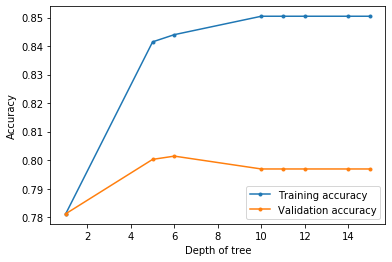

In [39]:
def dtc_parameter_tune(tain_val_X, train_val_y):
    depths = [1,5,6,10,11,12,14,15]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in depths:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            train_X = train_val_X.iloc[train_index,:]
            val_X = train_val_X.iloc[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = tree.DecisionTreeClassifier(max_depth=depth,
                                              random_state=seed,
                                              criterion='entropy',
                                              min_samples_split=4,
                                              min_samples_leaf=5)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            
        avg_train_acc = sum(train_acc) / len(train_acc) # compute the average training accuracy of K-folds CV
        avg_val_acc = sum(val_acc) / len(val_acc) # compute the average validation accuracy of K-folds CV
        print("Depth: ", depth)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return depths, train_acc_all, val_acc_all

depths, train_acc_all, val_acc_all = dtc_parameter_tune(train_val_X,train_val_y)

# plot training/validation curves
plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.legend()

In [40]:
best_index = val_acc_all.index(max(val_acc_all))
best_depth = depths[best_index]
dtc = tree.DecisionTreeClassifier(max_depth=best_depth,
                                  random_state=seed,
                                  criterion='entropy',
                                  min_samples_split=4,
                                  min_samples_leaf=5)
dtc.fit(train_val_X,train_val_y)
train_acc = dtc.score(train_val_X, train_val_y)

print("Best depth: ", best_depth)
print("Training accuracy: ", train_acc * 100, "%")
print("mean accuracy", np.mean(val_acc_all)* 100, "%")

Best depth:  6
Training accuracy:  84.51178451178451 %
mean accuracy 79.592304312347 %


In [41]:
# predict which passengers survived using the trained model
submit['Survived'] = dtc.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_dt_tuned.csv', index=False)
feature_imp = pd.Series(dtc.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

Mr/Sir                   0.504943
Pclass                   0.148659
Family                   0.087384
Speciality Profession    0.087018
Z                        0.060450
7_Family                 0.022963
Child                    0.022001
Master                   0.011109
CE                       0.009238
ABC                      0.008826
F                        0.008807
Teen                     0.008447
2_Family                 0.007063
QE                       0.005695
SE                       0.005023
1_Family                 0.002279
Miss/Lady                0.000096
Teen_Adult               0.000000
8_Family                 0.000000
male                     0.000000
female                   0.000000
6_Family                 0.000000
Adult                    0.000000
D                        0.000000
4_Family                 0.000000
E                        0.000000
Single Women             0.000000
G                        0.000000
5_Family                 0.000000
3_Family      

score of 79.19

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 o

Estimator:  1
Training accuracy:  81.0611516459965 %
Validation accuracy:  78.22861088443915 %


C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done

Estimator:  5
Training accuracy:  83.36176465953322 %
Validation accuracy:  81.82223338145754 %


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Don

Estimator:  6
Training accuracy:  83.58624738011568 %
Validation accuracy:  82.27104387671835 %


C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done

Estimator:  10
Training accuracy:  84.06306632837985 %
Validation accuracy:  81.82223338145754 %


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.0s finished
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  11 out of  11 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out

Estimator:  11
Training accuracy:  83.95090376160235 %
Validation accuracy:  81.70987383089573 %


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out

Estimator:  12
Training accuracy:  83.86675228895157 %
Validation accuracy:  82.15931203314292 %


C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.0s finished
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB

Estimator:  14
Training accuracy:  84.17530768867107 %
Validation accuracy:  82.15868432615656 %


C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB

Estimator:  15
Training accuracy:  84.1192067069039 %
Validation accuracy:  81.93396522503295 %


[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished


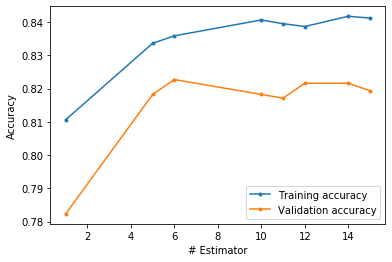

In [42]:
def clf_parameter_tune(tain_val_X, train_val_y):
    n_estimators = [1,5,6,10,11,12,14,15]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for estimator in n_estimators:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            train_X = train_val_X.iloc[train_index,:]
            val_X = train_val_X.iloc[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            clf = RandomForestClassifier(n_estimators=estimator,random_state=seed,
                                         criterion='entropy',min_samples_split=4,
                                        min_samples_leaf=5,oob_score=True,
                                         n_jobs=-1,verbose=1)
            clf.fit(train_X, train_y)
            train_acc.append(clf.score(train_X, train_y))
            val_acc.append(clf.score(val_X, val_y))
            
        avg_train_acc = sum(train_acc) / len(train_acc) # compute the average training accuracy of K-folds CV
        avg_val_acc = sum(val_acc) / len(val_acc) # compute the average validation accuracy of K-folds CV
        print("Estimator: ", estimator)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return n_estimators, train_acc_all, val_acc_all

n_estimators, train_acc_all, val_acc_all = clf_parameter_tune(train_val_X, train_val_y)

# plot training/validation curves
plt.plot(n_estimators, train_acc_all, marker='.', label="Training accuracy")
plt.plot(n_estimators, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('# Estimator')
plt.ylabel('Accuracy')
plt.legend()

In [43]:
best_index = val_acc_all.index(max(val_acc_all))
best_estimator = n_estimators[best_index]
clf = RandomForestClassifier(n_estimators=best_estimator,random_state=seed,
                             criterion='entropy',min_samples_split=4,
                             min_samples_leaf=5,oob_score=True,
                             n_jobs=-1,verbose=1)
clf.fit(train_val_X,train_val_y)
train_acc = clf.score(train_val_X, train_val_y)

print("Best estimator: ", best_estimator)
print("Training accuracy: ", train_acc * 100, "%")
print("mean accuracy", np.mean(val_acc_all)* 100, "%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\shash\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Best estimator:  6
Training accuracy:  83.16498316498317 %
mean accuracy 81.5132446174126 %


In [44]:
# predict which passengers survived using the trained model
submit['Survived'] = clf.predict(test[features])
submit = submit[['PassengerId','Survived']]
submit.to_csv('submit_RF_tuned.csv', index=False)
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


male                     0.191687
Mr/Sir                   0.175770
female                   0.136430
Pclass                   0.103269
Family                   0.065097
Z                        0.064124
Married Women            0.055083
ABC                      0.042833
1_Family                 0.037254
SE                       0.029740
Miss/Lady                0.029538
3_Family                 0.018900
E                        0.008399
Master                   0.006565
CE                       0.006496
2_Family                 0.006223
QE                       0.005269
Child                    0.004679
Adult                    0.004411
D                        0.002882
4_Family                 0.002536
5_Family                 0.001161
7_Family                 0.001006
Teen                     0.000312
Speciality Profession    0.000260
Teen_Adult               0.000076
F                        0.000000
G                        0.000000
Single Women             0.000000
6_Family      

score of 79.9

### TODO: make ADA boost model